# --------------------------------
# Part 1: Data import
# --------------------------------

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU(s) détecté(s): {len(gpus)} - Croissance mémoire activée")
    else:
        print("⚠️  Aucun GPU détecté - Utilisation du CPU")
except Exception as e:
    print(f"Configuration GPU: {e}")

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
keras.utils.set_random_seed(SEED)

print(f"\n📦 TensorFlow version: {tf.__version__}")
print(f"📦 Keras version: {keras.__version__}")

✅ GPU(s) détecté(s): 1 - Croissance mémoire activée

📦 TensorFlow version: 2.20.0
📦 Keras version: 3.12.0


In [34]:
iemocap = pd.read_csv('./data/iemocapTrans.csv')

iemocap.head(10)

,_id,activation,dominance,emotion,end_time,start_time,titre,to_translate,translated,valence
0,625682441da7a5c1eaef3689,2.5,3.5,sad,6.0541,3.9987,Ses02M_impro02_F000,I don't want you to go.,Je ne veux pas que tu partes.,2.5
1,625682441da7a5c1eaef368a,3.0,4.0,sad,15.1000,7.0366,Ses02M_impro02_M000,"I know, I know. I don't want to go either bab...",Je sais je sais. Je ne veux pas y aller non pl...,2.0
2,625682441da7a5c1eaef368b,2.5,4.5,sad,23.3599,15.5524,Ses02M_impro02_F001,I'm going to miss you too; I don't know what ...,Tu vas me manquer aussi; Je ne sais pas ce que...,1.5
3,625682441da7a5c1eaef368c,2.5,4.0,sad,26.4151,23.5790,Ses02M_impro02_F002,I don't want to be a single mom.,Je ne veux pas être une mère célibataire.,1.5
4,625682441da7a5c1eaef368d,3.0,3.5,sad,31.4253,26.7598,Ses02M_impro02_M001,You won't be. I'll be back; I'll be back befo...,Vous ne le serez pas. Je reviendrai; Je serai ...,3.5
5,625682441da7a5c1eaef368e,2.5,3.0,sad,32.6401,31.3058,Ses02M_impro02_F003,but,mais,2.0
6,625682441da7a5c1eaef368f,2.5,2.5,sad,33.6558,32.6800,Ses02M_impro02_M002,and,et,4.0
7,625682441da7a5c1eaef3690,3.0,4.0,sad,37.3201,33.4566,Ses02M_impro02_F004,It's dangerous; I mean how can you make sure ...,"C'est dangereux; Je veux dire, comment peux-tu...",2.0
8,625682441da7a5c1eaef3691,3.0,4.0,fru,44.4296,37.5389,Ses02M_impro02_M003,"It's- It's dangerous anywhere, honey. I mean ...","C'est... C'est dangereux n'importe où, chérie....",2.5
9,625682441da7a5c1eaef3692,4.0,4.0,sad,54.8649,44.4743,Ses02M_impro02_M004,"I'll come back we'll have, you know, some goo...","Je reviendrai, nous aurons, vous savez, de bon...",3.5


In [35]:
print(iemocap.count())
iemocap.nunique()

_id             10039
activation      10039
dominance       10039
emotion         10039
end_time        10039
start_time      10039
titre           10039
to_translate    10039
translated      10039
valence         10039
dtype: int64


_id             10039
activation         22
dominance          21
emotion            10
end_time         9369
start_time       9392
titre           10039
to_translate     8068
translated       7743
valence            21
dtype: int64

# --------------------------------
# Part 2: Data cleaning
# --------------------------------

## Remove the columns that doesn't fit the initial need

The initial dataset is about actors that are filmed with emotions, duration, intensity and so on.

As in our context we are in a consultant-client B2B meeting context transcripted by an AI like Leexi, **we will not have that much details they had with video recording**.

We will also focus on **full french meetings conversation**, so we don't need english and time-separated text.

In [36]:
iemocap.drop(
    columns=[
            "_id", # All unique
            "activation", # From video recording
            "dominance", # From video recording
            "end_time", # Not useful for us as we will use full transcript
            "start_time", # Not useful for us as we will use full transcript
            "titre", # All unique
            "to_translate", # We will focus our agent on french
            "valence", # From video recording
        ],
        inplace=True
    )

iemocap.head(10)

,emotion,translated
0,sad,Je ne veux pas que tu partes.
1,sad,Je sais je sais. Je ne veux pas y aller non pl...
2,sad,Tu vas me manquer aussi; Je ne sais pas ce que...
3,sad,Je ne veux pas être une mère célibataire.
4,sad,Vous ne le serez pas. Je reviendrai; Je serai ...
5,sad,mais
6,sad,et
7,sad,"C'est dangereux; Je veux dire, comment peux-tu..."
8,fru,"C'est... C'est dangereux n'importe où, chérie...."
9,sad,"Je reviendrai, nous aurons, vous savez, de bon..."


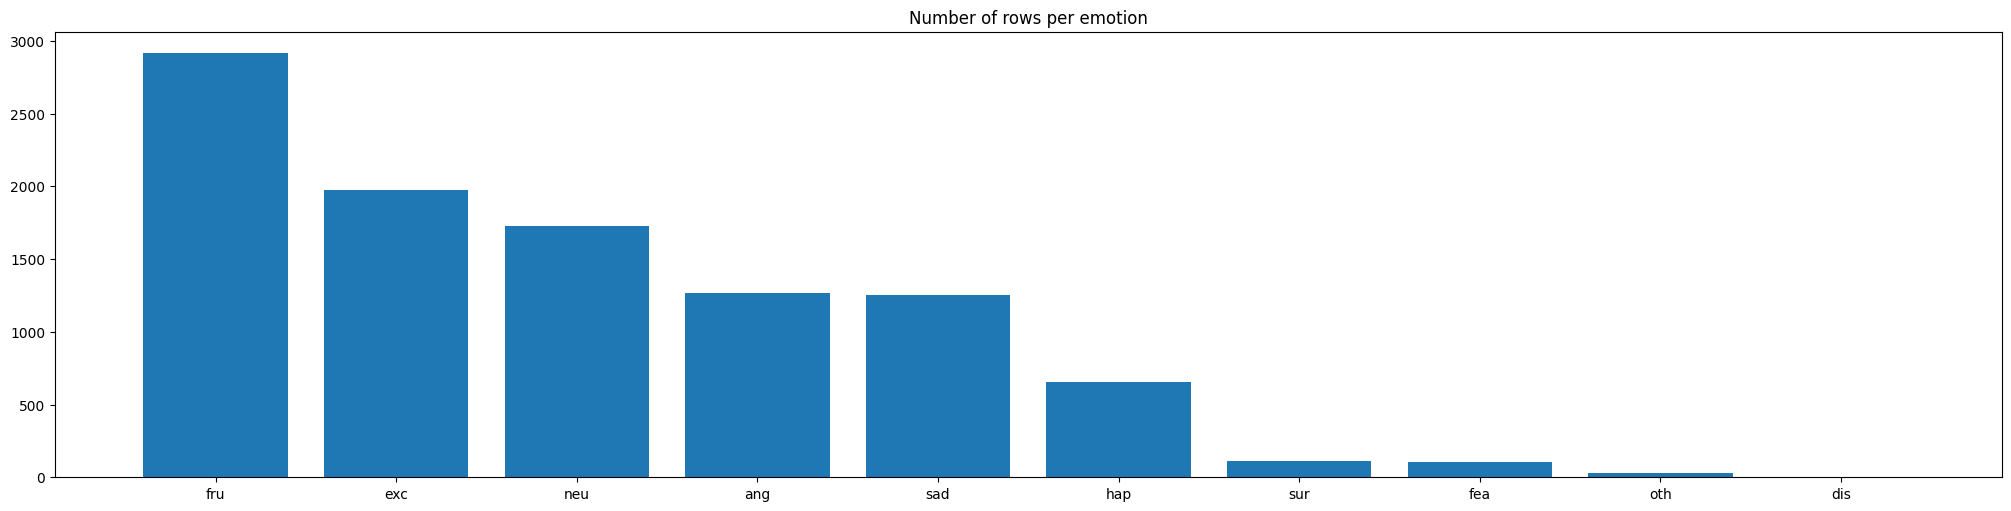

emotion
fru    2917
exc    1976
neu    1726
ang    1269
sad    1250
hap     656
sur     110
fea     107
oth      26
dis       2
Name: count, dtype: int64

In [37]:
iemocap_vcounts = iemocap['emotion'].value_counts()
fig, ax = plt.subplots(figsize=(20, 5), layout='constrained')
ax.set_title('Number of rows per emotion')
categories = iemocap_vcounts.index
ax.bar(categories, iemocap_vcounts.values)
plt.show()

iemocap['emotion'].value_counts()

In [38]:
length_dataframe = iemocap.copy()

length_dataframe['length'] = length_dataframe['translated'].str.len()

length_dataframe.head(10)

,emotion,translated,length
0,sad,Je ne veux pas que tu partes.,29
1,sad,Je sais je sais. Je ne veux pas y aller non pl...,104
2,sad,Tu vas me manquer aussi; Je ne sais pas ce que...,110
3,sad,Je ne veux pas être une mère célibataire.,41
4,sad,Vous ne le serez pas. Je reviendrai; Je serai ...,95
5,sad,mais,4
6,sad,et,2
7,sad,"C'est dangereux; Je veux dire, comment peux-tu...",67
8,fru,"C'est... C'est dangereux n'importe où, chérie....",116
9,sad,"Je reviendrai, nous aurons, vous savez, de bon...",183


length
13     62
9      49
31     44
4      43
32     41
       ..
211     1
250     1
362     1
360     1
254     1
Name: count, Length: 272, dtype: int64


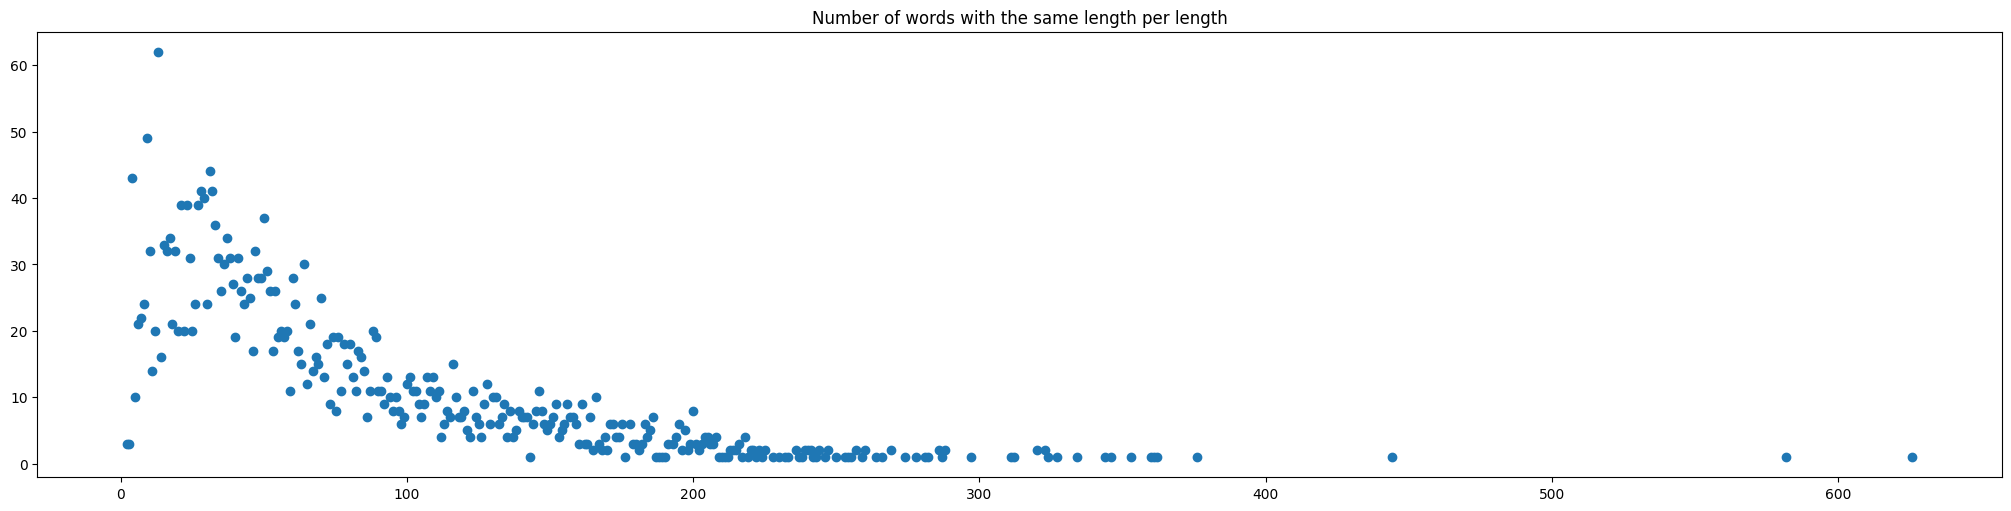

count    272.000000
mean      10.724265
std       11.185177
min        1.000000
25%        2.000000
50%        7.000000
75%       16.000000
max       62.000000
Name: count, dtype: float64

In [39]:
frustration = length_dataframe[length_dataframe['emotion'] == "fru"]

fru_len = frustration['length'].value_counts()

print(fru_len)

fig_score, ax_score = plt.subplots(figsize=(20, 5), layout='constrained')
ax_score.set_title('Number of words with the same length per length')
score_churned_x = fru_len.index
score_churned_y = fru_len.values
ax_score.plot(score_churned_x, score_churned_y, 'o')
plt.show()

fru_len.describe()

In [40]:
iemocap.isnull().sum()

emotion       0
translated    0
dtype: int64

In [41]:
frustration_short = length_dataframe[(length_dataframe['emotion'] == "fru") & (length_dataframe['length'] < 108)]

print(frustration_short.count())
print(frustration.count() - frustration_short.count())

fru_final = length_dataframe[(length_dataframe['emotion'] == "fru") & (length_dataframe['length'] > 107)]
fru_final.count()

emotion       2261
translated    2261
length        2261
dtype: int64
emotion       656
translated    656
length        656
dtype: int64


emotion       656
translated    656
length        656
dtype: int64

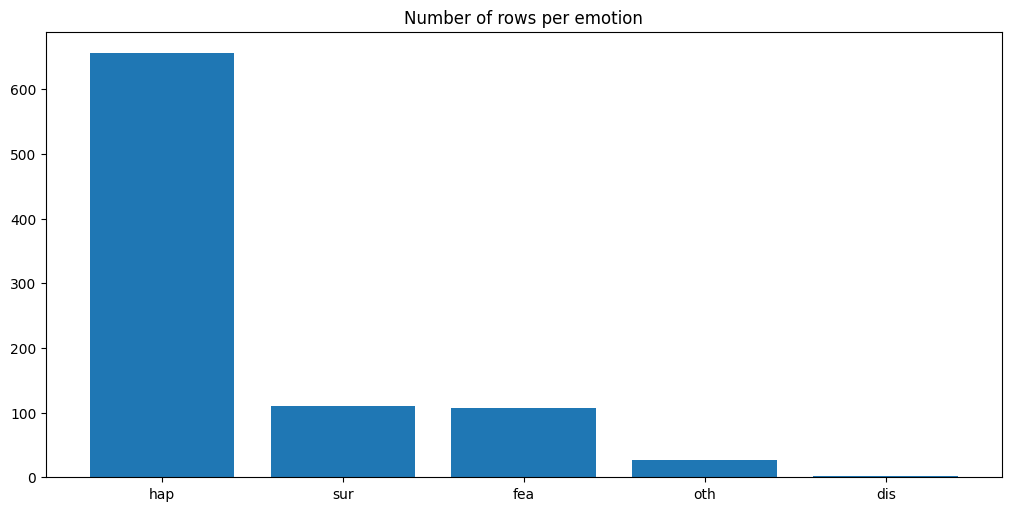

emotion
hap    656
sur    110
fea    107
oth     26
dis      2
Name: count, dtype: int64

In [42]:
balanced_dataframe = length_dataframe[
    (length_dataframe['emotion'] == "hap") | 
    (length_dataframe['emotion'] == "fea") | 
    (length_dataframe['emotion'] == "sur") | 
    (length_dataframe['emotion'] == "oth") |
    (length_dataframe['emotion'] == "dis")
]

balanced_counts = balanced_dataframe['emotion'].value_counts()
fig, ax = plt.subplots(figsize=(10, 5), layout='constrained')
ax.set_title('Number of rows per emotion')
categories = balanced_counts.index
ax.bar(categories, balanced_counts.values)
plt.show()

balanced_dataframe['emotion'].value_counts()

In [43]:
from sklearn.utils import resample

excited_short = length_dataframe[(length_dataframe['emotion'] == "exc") & (length_dataframe['length'] > 72)]

print(excited_short.count())

excited_final = resample(excited_short, replace=False, n_samples=656, random_state=42)
excited_final.count()

emotion       663
translated    663
length        663
dtype: int64


emotion       656
translated    656
length        656
dtype: int64

In [44]:
neutral_short = length_dataframe[(length_dataframe['emotion'] == "neu") & (length_dataframe['length'] > 58)]

print(neutral_short.count())

neutral_final = resample(neutral_short, replace=False, n_samples=656, random_state=42)
neutral_final.count()

emotion       668
translated    668
length        668
dtype: int64


emotion       656
translated    656
length        656
dtype: int64

In [45]:
anger_short = length_dataframe[(length_dataframe['emotion'] == "ang") & (length_dataframe['length'] > 53)]

print(anger_short.count())

anger_final = resample(anger_short, replace=False, n_samples=656, random_state=42)
anger_final.count()

emotion       657
translated    657
length        657
dtype: int64


emotion       656
translated    656
length        656
dtype: int64

In [46]:
sadness_short = length_dataframe[(length_dataframe['emotion'] == "sad") & (length_dataframe['length'] > 41)]

print(sadness_short.count())

sadness_final = resample(sadness_short, replace=False, n_samples=656, random_state=42)
sadness_final.count()

emotion       665
translated    665
length        665
dtype: int64


emotion       656
translated    656
length        656
dtype: int64

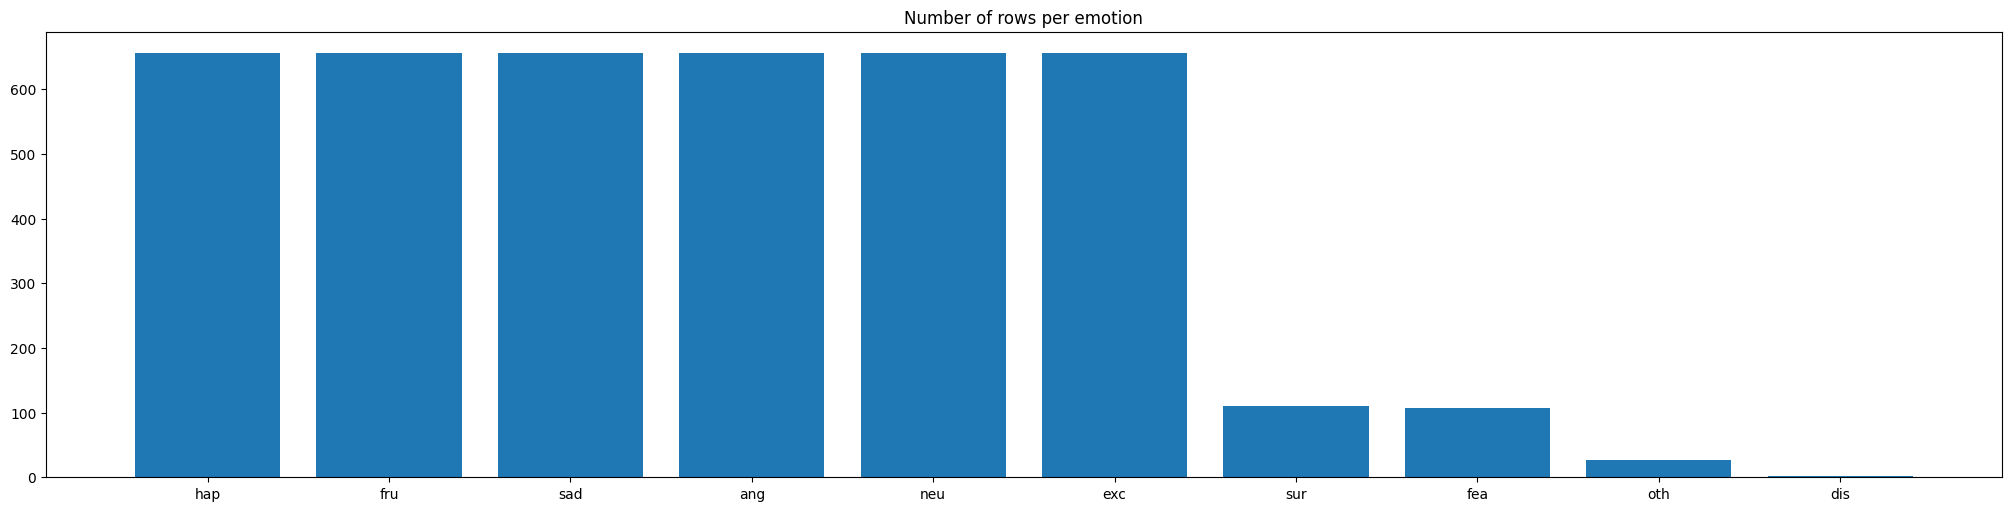

emotion       4181
translated    4181
length        4181
dtype: int64


emotion
hap    656
fru    656
sad    656
ang    656
neu    656
exc    656
sur    110
fea    107
oth     26
dis      2
Name: count, dtype: int64

In [47]:
balanced_final = pd.concat([balanced_dataframe, fru_final, excited_final, neutral_final, anger_final, sadness_final])

balanced_counts = balanced_final['emotion'].value_counts()
fig, ax = plt.subplots(figsize=(20, 5), layout='constrained')
ax.set_title('Number of rows per emotion')
categories = balanced_counts.index
ax.bar(categories, balanced_counts.values)
plt.show()

print(balanced_final.count())
balanced_final['emotion'].value_counts()

# --------------------------------
# Part 3: Pre-processing and camemBERT loading
# --------------------------------

To tokenize the text and prepare the training

In [48]:
from sklearn.preprocessing import LabelEncoder

label_encoded_final = balanced_final.copy()

label_encoder = LabelEncoder()
labels = label_encoded_final['emotion'].tolist()
label_encoded_final['encoded_emotion'] = label_encoder.fit_transform(labels)
y = label_encoded_final['encoded_emotion'].tolist()
inverse_labels = label_encoder.inverse_transform(label_encoded_final['encoded_emotion'])

label_encoded_final['emotion'] = y
label_encoded_final.drop(columns=['length', 'encoded_emotion'], inplace=True)
print(balanced_final.head())
label_encoded_final.head()

   emotion                           translated  length
36     hap                                 Une.       4
40     hap           Pourquoi le visage triste?      26
42     sur  Où? Qui? Qu'est-ce que tu racontes?      35
44     sur                La semaine prochaine?      21
98     sur                              Quelle?       7


,emotion,translated
36,5,Une.
40,5,Pourquoi le visage triste?
42,9,Où? Qui? Qu'est-ce que tu racontes?
44,9,La semaine prochaine?
98,9,Quelle?


In [49]:
# After a manual research
label2id = {'Anger':0, 'Disgust':1, 'Excitement':2, 'Fear':3, 'Frustration':4, 'Happiness':5, 'Neutral': 6, 'Other':7, 'Sadness':8, 'Surprise': 9}
id2label = {label: idx for idx, label in label2id.items()}

print("label2id:", label2id)
print("id2label:", id2label)

label2id: {'Anger': 0, 'Disgust': 1, 'Excitement': 2, 'Fear': 3, 'Frustration': 4, 'Happiness': 5, 'Neutral': 6, 'Other': 7, 'Sadness': 8, 'Surprise': 9}
id2label: {0: 'Anger', 1: 'Disgust', 2: 'Excitement', 3: 'Fear', 4: 'Frustration', 5: 'Happiness', 6: 'Neutral', 7: 'Other', 8: 'Sadness', 9: 'Surprise'}


In [50]:
import torch
from torch.utils.data import Dataset, DataLoader

class IntentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [51]:
from transformers import CamembertTokenizer, CamembertForSequenceClassification
from torch.optim import AdamW 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using ", device)

tokenizer = CamembertTokenizer.from_pretrained('camembert-base')
model = CamembertForSequenceClassification.from_pretrained(
    'camembert-base',
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)
model.to(device)

Using  cuda


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias

In [52]:
train, validation_test = train_test_split(label_encoded_final, test_size = 0.2, random_state=SEED, stratify=y)
print("Train:\t\t", len(train), "rows")

validation, test = train_test_split(validation_test, test_size = 0.5)
print("Validation:\t", len(validation), "rows")
print("Testing:\t", len(test), "rows")

train_X = train[['translated']]
train_y = train[['emotion']]

validation_X = validation[['translated']]
validation_y = validation[['emotion']]

test_X = test[['translated']]
test_y = test[['emotion']]

print("Train Y balance: ", train_y.value_counts())
print("Validation Y balance: ", validation_y.value_counts())
print("Testing Y balance: ", test_y.value_counts())

Train:		 3344 rows
Validation:	 418 rows
Testing:	 419 rows
Train Y balance:  emotion
0          525
2          525
8          525
4          525
6          525
5          524
9           88
3           85
7           21
1            1
Name: count, dtype: int64
Validation Y balance:  emotion
6          75
4          66
0          64
2          63
5          61
8          59
9          14
3          11
7           4
1           1
Name: count, dtype: int64
Testing Y balance:  emotion
8          72
5          71
2          68
0          67
4          65
6          56
3          11
9           8
7           1
Name: count, dtype: int64


In [53]:
import re

# Pre processing function
def pre_process(text):
    text = text.lower()
    text = re.sub(r"[^a-zàâäæçéèêëïîôùûüÿœ'\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

clean_train_X = [pre_process(phrase) for phrase in train_X['translated']]
clean_valid_X = [pre_process(phrase) for phrase in validation_X['translated']]
clean_test_X = [pre_process(phrase) for phrase in test_X['translated']]
print(train_X.head())
print(clean_train_X[0])
print(clean_train_X[1])
print(clean_train_X[2])
print(clean_train_X[3])
print(clean_train_X[4])

                                             translated
9106                                Exactement, "rire".
971   Et ça va -- le -- vous savez, je lui ai dit qu...
193   Je te déteste. Écoute, j'en ai marre de t'écou...
1718  Eh bien, le problème, c'est que j'avais prévu ...
9893  Bien sûr, je voulais un peu plus loin sur la c...
exactement rire
et ça va le vous savez je lui ai dit que je je veux que la couleur brune fasse partie intégrante du mariage et euh peutêtre des verts et des bleus
je te déteste écoute j'en ai marre de t'écouter brute sadique
eh bien le problème c'est que j'avais prévu de te surprendre pendant environ une semaine et ils tiennent pour acquis que nous sommes tous prêts
bien sûr je voulais un peu plus loin sur la côte vous savez loin de toutes les lumières des gens et de tout estil minuit commencentils toujours à minuit estce qu'il est minuit comment ça va hein ça va c'est bon


In [54]:
train_dataset = IntentDataset(clean_train_X, train_y['emotion'].tolist(), tokenizer)
validation_dataset = IntentDataset(clean_valid_X, validation_y['emotion'].tolist(), tokenizer)
test_dataset = IntentDataset(clean_test_X, test_y['emotion'].tolist(), tokenizer)
    
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8)

#encoded_train_X = tokenizer(clean_train_X, padding=True, truncation=True, return_tensors="tf")
#encoded_valid_X = tokenizer(clean_valid_X, padding=True, truncation=True, return_tensors="tf")
#encoded_test_X = tokenizer(clean_test_X, padding=True, truncation=True, return_tensors="tf")
#
#print(encoded_train_X)

# --------------------------------
# Part 4: Train camemBERT
# --------------------------------

In [55]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.path = path

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [56]:
def train_model(train_dataloader, validation_dataloader, model, optimizer, device, early_stopper, epochs=3):
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_dataloader:
            optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_loss += loss.item()
            
            loss.backward()
            optimizer.step()
        
        avg_loss = total_loss / len(train_dataloader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in validation_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)
                
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                loss = outputs.loss
                val_loss += loss.item()
        val_loss /= len(validation_dataloader)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}")

        if early_stopper.early_stop(val_loss):
            print(f"Stopping training at epoch {epoch + 1}")
            break

In [57]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from torch.utils.data import Dataset, DataLoader

loss = SparseCategoricalCrossentropy()
optimizer = AdamW(model.parameters(), lr=5e-5)
early_stopper = EarlyStopper(patience=10, min_delta=0.1)

train_model(train_dataloader, validation_dataloader, model, optimizer, device, early_stopper, epochs=150)

#training_args = TrainingArguments(
#        save_strategy="epoch",
#        eval_strategy="epoch",
#        learning_rate=2e-5,
#        weight_decay = 0.01,
#        push_to_hub=False,
#        load_best_model_at_end=True,
#        logging_strategy="epoch",
#        report_to='none',
#    )
#
#data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#trainer = Trainer(
#    model=model,
#    training_args=training_args,
#    train_dataset=train_dataset,
#    eval_dataset=eval_dataset,
#    data_collator=data_collator,
#    processing_class=tokenizer
#)

# 3e-6 Epoch 20/20, Loss: 0.5540, acc 0.57
# 4e-6 Epoch 20/20, Loss: 0.3693, acc 0.57
# 5e-6 Epoch 20/20, Loss: 0.2900, acc 0.57
# 5e-5 Epoch 20/20, Loss: 0.2653, acc 0.59
#   -> Same with val loss and early stopper : acc 0.63

Epoch 1/150, Train Loss: 1.7437, Val Loss: 1.5200
Epoch 2/150, Train Loss: 1.2094, Val Loss: 1.3780
Epoch 3/150, Train Loss: 0.8618, Val Loss: 1.3210
Epoch 4/150, Train Loss: 0.6453, Val Loss: 1.4895
Epoch 5/150, Train Loss: 0.5190, Val Loss: 1.4921
Epoch 6/150, Train Loss: 0.4158, Val Loss: 1.5207
Epoch 7/150, Train Loss: 0.3414, Val Loss: 1.8376
Epoch 8/150, Train Loss: 0.3340, Val Loss: 1.7257
Epoch 9/150, Train Loss: 0.2849, Val Loss: 1.9103
Epoch 10/150, Train Loss: 0.2254, Val Loss: 1.7908
Epoch 11/150, Train Loss: 0.2108, Val Loss: 1.9386
Epoch 12/150, Train Loss: 0.2289, Val Loss: 1.8446
Epoch 13/150, Train Loss: 0.2634, Val Loss: 1.8588
Stopping training at epoch 13


In [58]:
# Load best model
model.load_state_dict(torch.load(early_stopper.path))

<All keys matched successfully>

# --------------------------------
# Part 5: Evaluation
# --------------------------------

In [59]:
from sklearn.metrics import accuracy_score

def evaluate_model(dataloader, model, device):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return predictions, true_labels

predictions, true_labels = evaluate_model(test_dataloader, model, device)

# Disgust not in test dataset
test_label2id = label2id
test_label2id.pop('Disgust')

print('Fine-tuned camemBERT Accuracy on test set : '+ str(accuracy_score(predictions, test_y)))
    
print("\nClassification report:")
print(classification_report(
    true_labels,
    predictions,
    target_names=list(test_label2id.keys())
))

#{'Anger':0, 'Disgust':1, 'Excitement':2, 'Fear':3, 'Frustration':4, 'Happiness':5, 'Neutral': 6, 'Other':7, 'Sadness':8, 'Surprise': 9}
#Sadness    72
#5          71
#2          68
#Anger      67
#4          65
#6          56
#3          11
#9           8
#7           1

Fine-tuned camemBERT Accuracy on test set : 0.6372315035799523

Classification report:
              precision    recall  f1-score   support

       Anger       0.84      0.46      0.60        67
  Excitement       0.57      0.79      0.67        68
        Fear       0.50      0.09      0.15        11
 Frustration       0.68      0.68      0.68        65
   Happiness       0.72      0.66      0.69        71
     Neutral       0.57      0.61      0.59        56
       Other       0.00      0.00      0.00         1
     Sadness       0.63      0.72      0.68        72
    Surprise       0.29      0.50      0.36         8

    accuracy                           0.64       419
   macro avg       0.53      0.50      0.49       419
weighted avg       0.66      0.64      0.63       419



In [60]:
#Base model
#base_model = CamembertForSequenceClassification.from_pretrained(
#    'camembert-base',
#    num_labels=10,
#    id2label=id2label,
#    label2id=label2id,
#    output_attentions=True
#)
#base_model.to(device)

#base_predictions, base_true_labels = evaluate_model(test_dataloader, base_model, device)

#print('Base camemBERT Accuracy on test set : '+ str(accuracy_score(base_predictions, test_y)))
    
#print("\nClassification report:")
#print(classification_report(
#    base_true_labels,
#    base_predictions
#))

In [61]:
def predict_intent(text, model, tokenizer, device):
    model.eval()
    
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        pred = torch.argmax(probs, dim=1)
        confidence = probs[0][pred].item()
    
    return id2label[pred.item()], confidence

test_texts = [
    "Bonjour Ludovic, je vois que le projet avance bien, nous voudrons ajouter votre dernier modèle de Machine Learning que nous avions vu sur Linkedin.",
    "Le but c'est de créer une plateforme entre consultants et entreprises, je ne vois pas l'intérêt de faire du churn client.",
    "Je pense qu'avec cette idée nous allons dans le mur. Vous me demandez de faire un projet en 7 jours alors qu'il me faudrait au moins deux mois pour le faire, ça ne tient pas debout",
    "C'est ça, et en fait, le problème, je le sais et ils ne veulent pas, ils refusent systématiquement la connexion. Puisque j'ai plusieurs comptes Gmail, j'ai des comptes Pro. Et donc lui considère que c'est du pro, donc il ne veut pas connecter le Workspace. Donc je dois me connecter avec une page cachée, ou un zéro-log, etc. Je le fais.",
    "Si on reprend le sprint actuel, il n'a pas été modifié du coup. On est toujours dans l'écho parce que c'est l'avancée du machine learning et qui est très avancée. On peut faire le point par contre sur les atteints non atteints. Je vais modifier quelques trucs par rapport à ce qu'on a dit Ludo hier, par rapport à ce que tu avais fait. C'est à dire qu'en fait je vais modifier par rapport à ce que tu avais fait.",
    "Je comprends bien qu'il faut chercher un dataset, pouvoir nourrir le... Mais qu'est-ce qu'on doit faire ? Qu'est-ce qui a été demandé par les profs ? Et j'ai juste besoin d'un tout petit peu de contexte, d'un peu de technique. Je ne sais pas si un de vous peut me l'expliquer. Nicole",
    "Il n'y a pas de chiffre d'affaires par année, ils font du volume, ils n'ont pas le temps, on peut leur mettre l'IA mais ils ont même le budget mais ils ne vont pas savoir compter un petit peu, ils savent que ça fonctionne, qu'il faut être dedans mais ils ne le font pas donc on aimerait bien.",
    "Est-ce que ça vaut le coup de continuer à bosser sur le projet ou est-ce que dans tous les cas il y a 90% de chance que ça n'aille pas plus loin et on évite au résultant de perdre son temps ? son énergie sur ce pion-là."
]
    
for text in test_texts:
    intent, confidence = predict_intent(text, model, tokenizer, device)
    print("\nPhrase: '", text)
    print("Intention: ", intent)
    print(f"Confiance: {confidence:.2%}")


Phrase: ' Bonjour Ludovic, je vois que le projet avance bien, nous voudrons ajouter votre dernier modèle de Machine Learning que nous avions vu sur Linkedin.
Intention:  Excitement
Confiance: 52.60%

Phrase: ' Le but c'est de créer une plateforme entre consultants et entreprises, je ne vois pas l'intérêt de faire du churn client.
Intention:  Neutral
Confiance: 41.06%

Phrase: ' Je pense qu'avec cette idée nous allons dans le mur. Vous me demandez de faire un projet en 7 jours alors qu'il me faudrait au moins deux mois pour le faire, ça ne tient pas debout
Intention:  Frustration
Confiance: 64.03%

Phrase: ' C'est ça, et en fait, le problème, je le sais et ils ne veulent pas, ils refusent systématiquement la connexion. Puisque j'ai plusieurs comptes Gmail, j'ai des comptes Pro. Et donc lui considère que c'est du pro, donc il ne veut pas connecter le Workspace. Donc je dois me connecter avec une page cachée, ou un zéro-log, etc. Je le fais.
Intention:  Frustration
Confiance: 59.61%

Phr

PART 6 : Register

In [62]:
model.save_pretrained('balanced_model_2/')
tokenizer.save_pretrained('balanced_model_2/')
print("Model saved!")

Model saved!
